In [3]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn.svm import SVC
import hpsklearn
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, SparkTrials
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize, scale
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score
# import mlflow

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, recall_score, accuracy_score, f1_score, roc_auc_score

Load Data from Disk

In [14]:
train_df = pd.read_csv('data/training.csv')
test_df = pd.read_csv('data/testing.csv')
group_train = pd.read_csv('data/group_training.csv')
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]
X_train.nunique()

race                          5
gender                        3
age                          10
admission_type_id             8
discharge_disposition_id     26
admission_source_id          17
time_in_hospital             14
num_lab_procedures          117
num_procedures                7
num_medications              74
number_outpatient            37
number_emergency             33
number_inpatient             21
number_diagnoses             16
max_glu_serum                 4
A1Cresult                     4
metformin                     4
repaglinide                   4
nateglinide                   4
chlorpropamide                4
glimepiride                   4
glipizide                     4
glyburide                     4
tolbutamide                   2
pioglitazone                  4
rosiglitazone                 4
acarbose                      4
miglitol                      4
troglitazone                  2
tolazamide                    2
insulin                       4
glyburid

# Preprocessing and Metrics

In [5]:
# Scaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scorer
scorers={
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'macro_f1': make_scorer(f1_score, average='macro'),
    'weighted_f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score)
}

def compute_scores(y_test, y_pred):
    return pd.DataFrame({
        'recall':          recall_score(y_test, y_pred),
        'accuracy':        accuracy_score(y_test, y_pred),
        'macro_f1':        f1_score(y_test, y_pred, average='macro'),
        'weighted_f1':     f1_score(y_test, y_pred, average='weighted'),
        'macro_roc':       roc_auc_score(y_test, y_pred, average='macro'),
        'weighted_roc':    roc_auc_score(y_test, y_pred, average='weighted')
    }, index=[0])

In [65]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

(100, 38) (100, 38) (100, 76)


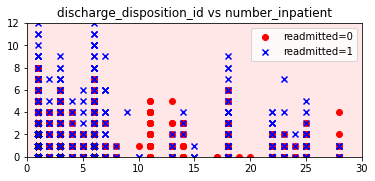

In [39]:
def plot_data(feature_names):
    if len(feature_names) > 2:
        return
    plt.title('{} vs {}'.format(*feature_names))
    plt.scatter(*X_test[y_test==0][feature_names].to_numpy().T, marker="o", c="r", label='readmitted=0')
    plt.scatter(*X_test[y_test==1][feature_names].to_numpy().T, marker="x", c="b", label='readmitted=1')
    plt.legend()

plot_data(['discharge_disposition_id', 'number_inpatient'])

In [7]:
# CV Split
gkf = GroupKFold(n_splits=5)

# Classifier
clf = SVC(verbose=True, random_state=42)

# Parameter Search with HyperOpt

Use small subset of data

In [8]:
train_df_small = train_df.sample(n=len(train_df)//10, random_state=42)
X_train = train_df_small.iloc[:, :-1]
y_train = train_df_small.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

Define parameter space

In [9]:
svc_param_dist = {
    'C': hp.lognormal('SVM_C', 0, 10),
    'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf']),
    'degree': hp.quniform('degree', 1, 9, 1),
    'cache_size': (512,),
}

Find best combination

In [ ]:
estim = hpsklearn.HyperoptEstimator(classifier=hpsklearn.svc('svc', 
#                                                              C=svc_param_dist['C'], 
#                                                              kernels=svc_param_dist['kernel'], 
#                                                              degree=svc_param_dist['degree'],
                                                             cache_size=512, random_state=42),
                                  preprocessing=[hpsklearn.standard_scaler('scaler')],
                                  algo=tpe.suggest)

estim.fit(X_train, y_train)

Evaluate combination

In [ ]:
print(estim.best_model())

estim.score(X_test_scaled, y_test)

print(sklearn.metrics.classification_report(y_test, X_test_scaled))
plot_confusion_matrix(estim.best_model()['learner'], X_test_scaled, y_test, cmap='Blues')

# Parameter Search with GroupKFold and RandomizedSearchCV

In [ ]:
param_dist = {
    'C': scipy.stats.reciprocal(0, 10),
    'gamma': scipy.stats.reciprocal(0.00001, 1),
    'kernel': ('linear', 'poly', 'rbf'),
    'degree': scipy.stats.randint(1, 9),
    'cache_size': (256, 512),
}

In [ ]:
rs = sklearn.model_selection.RandomizedSearchCV(clf, param_dist, n_iter=100, scoring=scorers, refit='macro_f1', cv=gkf, verbose=1, n_jobs=-1, random_state=42)

In [ ]:
rs.fit(X_train_scaled, y_train, groups=group_train)

In [ ]:
print(rs.best_estimator_)
print(roc_auc_score(t_test, svc_tuned.predict(X_test_scaled)))

In [ ]:
print(sklearn.metrics.classification_report(y_test, rs.predict(X_test_scaled)))
plot_confusion_matrix(rs.best_estimator_, X_test_scaled, y_test, cmap='Blues')

# Training Baseline SVC

In [61]:
svc_base = SVC(verbose=True, random_state=42)
svc_base.fit(X_train_scaled, y_train)

[LibSVM]

SVC(random_state=42, verbose=True)

   accuracy  macro_f1  weighted_f1  macro_roc  weighted_roc
0  0.637198  0.620663     0.627266   0.624129      0.624129


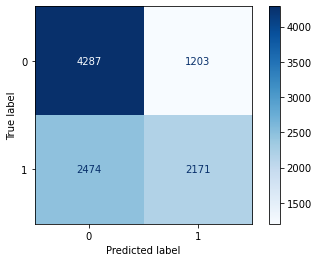

In [68]:
y_pred = svc_base.predict(X_test_scaled)
print(compute_scores(y_test, y_pred))
plot_confusion_matrix(svc_base, X_test_scaled, y_test, cmap='Blues')

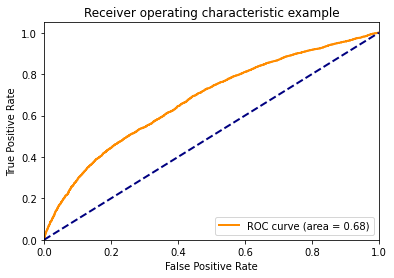

In [67]:
y_score = svc_base.decision_function(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

# Training Tuned SVC

In [15]:
svc_tuned = SVC(C=0.6858624371468123, cache_size=512, degree=1, gamma=0.01522615582638822, max_iter=232704699.0, random_state=42, tol=0.00915761916281012)
svc_tuned.fit(X_train_scaled, y_train);

   accuracy  macro_f1  weighted_f1  macro_roc  weighted_roc
0  0.636112  0.612797     0.620719   0.619963      0.619963


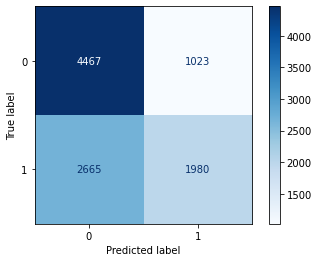

In [69]:
y_pred = svc_tuned.predict(X_test_scaled)
print(compute_scores(y_test, y_pred))
plot_confusion_matrix(svc_tuned, X_test_scaled, y_test, cmap='Blues')

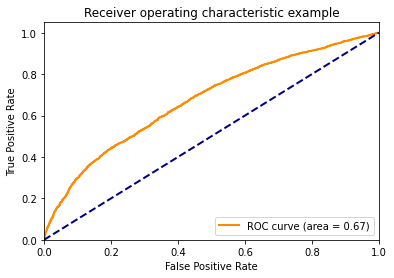

In [60]:
# Compute ROC curve and ROC area for each class
y_score = svc_tuned.decision_function(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

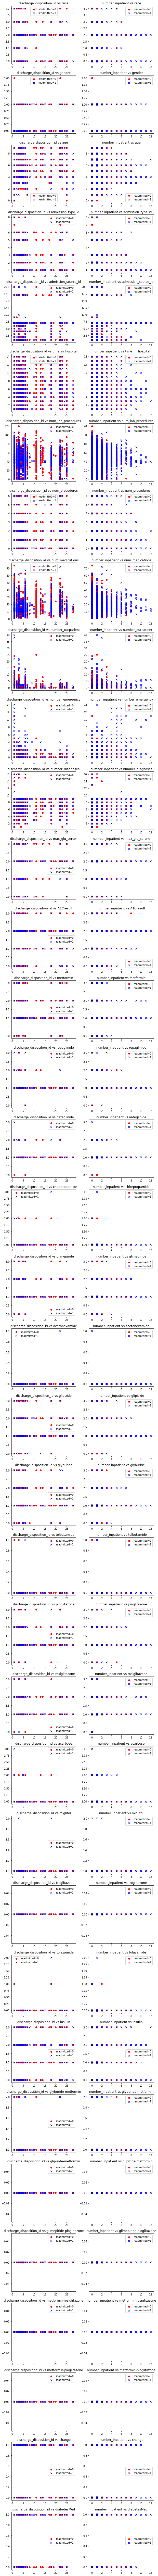

In [162]:
plt.gcf().set_size_inches(10,39*5)
feature_names = ['discharge_disposition_id', 'number_inpatient']
i=1
for col2 in X_test.columns[:39]:
    if col2 in feature_names:
        continue
    for col1 in feature_names:
        plt.subplot(39, 2, i)
        i+=1
        plot_data([col1, col2])